# Modeling US Corn and Soybeans Prevented Plantings
## Introduction
In this notebook, we will attempt to create a model to predict the area that will be claimed as "Prevented Plant" (PP) for a given year. This is not intended to be the most sophisticated model possible. Rather it illustrates the use of **Gro Intelligence** data and API combined with standard machine learning packages in answering a practically important question in a timely manner. GRO catalogues and makes available a large number of sources of data through its web application and API. Access to this data allows our clients to predict agriculture related metrics and numbers as the presented example demonstrates.
 
  We release complete and fully operational Python 3 code for our models and encourage user experimentation with specific model itself as well as GRO data and API in general.
  
## The Approach
Adverse weather conditions at planting time are the primary cause of loss under "Prevented Planting" insurance claims. While such conditions could include drought, wind, hail, and other type of events, the overwhelming majority of cases involves flooding. A good example is the flooding that impacted the US Corn and Soy Belts in 2019. Prevented plant area is reported at a county level and GRO accumulates such data in its system as well as abundance of data on wheather and soil conditions.

 Given above observations, we choose to model prevented plant area of each county as a function of county-level precipitation and soil moisture over preceeding period and the weekly survey of state-level planting progress for that year. Naturally, other sources of information can be added to the set of explanatory variables if desired.

Furthermore, due to the fact that corn is planted earlier than soybeans, using corn planting progress as well as prevented plant data (either actual numbers or, if early in the season, those predicted by a PP model for corn) as a feature could potentially improve the prediction of soybeans prevented plant. Therefore we also explore a model for predicting soybeans prevented plant which uses crop-progress reports and corn model output as additional inputs. For user-friendly information on spesific datasets used in this notebook as well as others available from GRO, sign up for our web-based platform at https://gro-intelligence.com/

## Notebook Layout and Usage
Notebook cells often rely on results computed in previous cells and intended to be run in the order presented. We follow standard sequence of events in building machine learning models:
1. download and clean the data
2. explore available data
3. fit models (we use linear regression and gradiant boosting trees)
4. visualize/analyse model resuslts
5. repeat steps above to improve/extend the model

As this notebook is intened mostly as an illustration of GRO data use we do not perform extensive model analysis/validation/tuning (such as boosting trees meta-parameter adjustment based on cross-validation). 

Note that the first run of the notebook will involve downloading significant amount of data from GRO system (step 1) which can take a while depending on network connection, system load, etc. Most of the data will be then cached in local files and these costs will not occur on subsequent runs for the same crop. To trigger re-download, delete corresponding files and rerun the notebook.

Steps 1 to 4 are almost identical for corn and soy crops. They differ only by using different metric/item IDs and taking care of somewhat different missing data patterns. At the end of the notebook we also show limited experiments with an augmented soy PP model which incorporates corn PP model results and some extra variables.

We recommend to run the notebook with crop='corn' first. This will generate data necessary for soy model extensions. You can certainly run crop='soy' first but in this case only the base version of soy model will be operational until a corn run is done. Please pay attention to any errors reported in step 5 to make sure extension results are valid.

Additional information and comments are provided throughout the notebook, both in code and markdown cells below.

## Initial Set-up
We assume standard Python 3 infrastructure with common numerical packages (numpy, pandas and matplotlib) installed.  A popular machine learning package sklearn is used to fit linear regressions and compute error metrics. To download data from our system your subscription should include <font color='red'>acess to GRO API</font>. Please contact us for arranging such access.

There are two packages implementing ensemble boosting trees you can use for this project:
1. Extreme Gradient Boosting from package **xgboost**
2. Gradient Boosting Trees from **sklearn**

Unfortunately, **xgboost** is not easily compatible with Windows environment. If you are operating on a Windows machine feel free to use **sklearn**, which has fundamentally the same implementation, but might incur somewhat longer running time.

Although not requied by the model itself, in order to plot the choropleth maps present in this notebook, you will also need to install package called **geopandas**. For Windows users it is best installed by using anaconda and the command 'conda install geopandas'. Please see http://geopandas.org/install.html for further details.

Please see accompanying README file for more details.

In [1]:
# For Python 2 compatibility
from __future__ import print_function,division

# The two packeages implement conceptually the same algorithm
# but xgboost contains multiple optimization
# See https://pypi.org/project/xgboost/ regarding xgboost on Windows in particular.
try:
    from xgboost import XGBRegressor
    gbt_model = XGBRegressor(objective='reg:squarederror')
    print("Will use XGBoost implementation of Gradient Boosting Trees")
except:
    from sklearn.ensemble import GradientBoostingRegressor
    gbt_model = GradientBoostingRegressor()
    print("Will use sklearn implementation of Gradient Boosting Trees")

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

import pandas as pd
import numpy as np
import itertools
import datetime
import os
import pickle

import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from api.client.gro_client import GroClient

#######################
# Top-level controls
######################

##########################################
# Set this to 'corn' or 'soy' to run model for corresponding crop
# Note that to explore extensions of soy model you should run corn model first
##########################################
crop = "corn" 

DEBUG = False
overwrite_prior_data = True
pickle_protocol = 2 # want to support Python 2 pickle format
start_year = 2011
end_year = 2019 # year for which we will be forecasting
end_year_data_available = True # as of August 2019
num_samples = end_year - start_year +1 # include end/start

### Initialize GRO API Client #######
api_host = "api.gro-intelligence.com"
client = GroClient(api_host, os.environ["GROAPI_TOKEN"])

soybelt_region_id = 100000101
cornbelt_region_id = 100000100
# test if API is operational
print(client.lookup("regions", soybelt_region_id)) 

# stubs for saving/loading data
def s(data, name, crop_name=""):
    with open(name + "_" + crop_name + ".pickle", "wb") as handle:
        pickle.dump(data, handle, protocol=pickle_protocol)
        
def l(name, crop_name=""):
    with open(name + "_" + crop_name + ".pickle", "rb") as handle:
        return pickle.load(handle)

Will use XGBoost implementation of Gradient Boosting Trees
{'contains': [13054, 13064, 13065, 13066, 13067, 13068, 13069, 13073, 13074, 13075, 13076, 13078, 13084, 13085, 13086, 13092, 13093, 13100], 'id': 100000101, 'latitude': None, 'level': 8, 'longitude': None, 'name': 'US Soybean Belt States', 'rankingScore': None}


# Stage 0: Get basic data (crop, states, counties)

First we will define the crops we want to model prevented plant for, and include their respective IDs. In this case we use two separate items from the Gro ontology - the canonical "Corn" (id:274) and "Corn, Planted" (id:3231) which represents "planted corn" and is the ID used in the planting progress data series. Both of these were taken from the Gro web interface "more information" function.

Some models will also use geographic information. Gro has a single latitude/longitude pair associated with each county

In [2]:
crops = {
    "corn": {
        "progress_id": 3231,
        "id": 274
    },
    "soy": {
        "progress_id": 2904,
        "id": 270
    }
}

# get belt state ids ...
if crop=='soy':
    belt_id = soybelt_region_id
else:
    belt_id = cornbelt_region_id

state_ids = {
    client.lookup("regions", state_id)["name"]: state_id 
    for 
    state_id 
    in client.lookup('regions', belt_id)["contains"]
}
#state_ids_inv = {state_id: state_name for (state_name, state_id) in state_ids.items()}

# ... and counties in each of these states
# Note: level 5 in region hierarchy corresponds to counties in the US
county_ids = {
    state_id: [county["id"] for county in client.get_descendant_regions(state_id, 5)]
    for state_id in state_ids.values()
}
all_counties = list(itertools.chain.from_iterable(county_ids.values()))
num_counties = len(all_counties)
print("There are {} counties in the US {} belt across {} states".
      format(num_counties,crop,len(state_ids)))

# Note: For corn only, Gro analysts recommended a patch to move ILLINOIS over IOWA
# in the latest (2019) year. Get corresponding location difference - it will be used later
iowa_state = client.lookup('regions', 13066)
illi_state = client.lookup("regions", 13064)
IA_IL_dlat = iowa_state.get("latitude") - illi_state.get("latitude")
IA_IL_dlon = iowa_state.get("longitude") - illi_state.get("longitude")

# load county locations
county_location=pd.DataFrame(np.nan, index=all_counties, columns=['latitude','longitude'])
county_location.index.name = 'county'
for county_id in all_counties:
    county = client.lookup('regions', county_id)  
    county_location.loc[county_id] = (county.get('latitude'), county.get('longitude'))            
        

There are 918 counties in the US corn belt across 10 states


# STAGE I: Data collection
Typycally we have to first check what is available via get_data_series (see FSA acreage data pull below) and deal with the possibility of multiple time series being returned. However, if we know parameters to pass to get_data_points so that it returns exactly the single time series we need, we do not need to aggregate and can optimize the process by getting data directly (see all other data pulls)


## State-level planting progress (from NASS, weekly)

In [3]:
%%time
soy_state_ids = {}
soy_county_ids = {}
try: 
    state_progress_data = l("state_progress_data_pd", crop_name=crop)
except:
    print("no cached progress file")
    # For soy we proceed as is, but for corn expand state coverage to soybelt
    # to cache entire data for future use by soy model
    if crop=='corn':
        if not soy_state_ids:
            soy_state_ids = {
                client.lookup("regions", state_id)["name"]: state_id 
                for state_id in client.lookup('regions', soybelt_region_id)["contains"]
            }
            for state_id in soy_state_ids.values():
                if state_id in state_ids:
                    soy_county_ids[state_id] = county_ids[state_id]
                else:
                    soy_county_ids[state_id] = [county["id"] for county in 
                                        client.get_descendant_regions(state_id, 5)]
    else:
        soy_state_ids = state_ids
        soy_county_ids = county_ids
    
    state_progress_data = pd.DataFrame()
    for state_id in soy_state_ids.values():
        df = pd.io.json.json_normalize(client.get_data_points(**{
            'metric_id': 2860042, # planting progress
            'item_id': crops[crop]["progress_id"],
            'region_id': state_id, 
            'source_id': 25, # NASS
            'frequency_id': 2 # weekly
        }))[['end_date','value']]
        df['end_date'] = pd.to_datetime(df['end_date'])
        df['year'] = df['end_date'].dt.year
        df['week'] = df['end_date'].dt.week # end_date is Sunday, so no extra adjustments needed
        df = df[(df['year']>=start_year) & (df['year']<=end_year)]
        data_start = pd.Series(0,index=range(start_year,end_year+1))
        data_start.loc[:] = df.groupby('year').min()['week']
        data_end = pd.Series(0,index=range(start_year,end_year+1))
        data_end.loc[:] = df.groupby('year').max()['week']
        # If missing, assume linear planting from week 13 to 22
        # which is roughly average corn progress
        data_start.fillna(13,inplace=True)
        data_end.fillna(22,inplace=True)

        df.set_index(['year','week'], inplace=True)
        df_interp = pd.DataFrame(index=pd.MultiIndex.from_product([
                                    range(start_year,end_year+1),
                                    range(1,54)],
                                        names=['year','week']))
        df_interp['prog'] = df['value']
        
        # Set 0/100 values before/after planting season ...
        zero_prog_idx = pd.concat([data_start] * 53).sort_index()
        df_interp[df_interp.index.get_level_values(level='week') < zero_prog_idx] = 0
        full_prog_idx = pd.concat([data_end] * 53).sort_index()
        df_interp[df_interp.index.get_level_values(level='week') > full_prog_idx] = 100
        # ... and interpolate the rest
        df_interp.interpolate(inplace=True)
        
        # other data are on county level, so replicate for each county in the state
        for county_id in soy_county_ids[state_id]:
            state_progress_data = pd.concat([state_progress_data,
                    pd.concat([df_interp],keys=[county_id], names=['county'])])
            
    if overwrite_prior_data:
        s(state_progress_data, "state_progress_data_pd", crop_name=crop)

# No-op for soy
state_progress_data = state_progress_data.loc[all_counties,:]

CPU times: user 1.11 s, sys: 328 ms, total: 1.44 s
Wall time: 1.42 s


## County-level soil moisture (from SMOS, daily)

Read daily SMOS data, convert to weekly averages.
Note that we will have no valid point if entire week of data is missing, so for each county we linearly interpolate these from surrounding weeks 

Weeks always start Monday, so first week of the year could be short
and some years will have data for the 53-rd week
We will ignore these issues as US growing season is far from start/end of the year

In [4]:
%%time

# County-level soil and precipitation data are not crop-specific. To save costs and time
# we download all needed counties the first time any of models is run rather than
# doing separate downloads for corn and soy.

try:
    # Check for common file (not _corn/_soy)
    county_smos_data = l("county_smos_data_pd")
except:
    print("no cached SMOS file")
    if crop=='corn':
        if not soy_state_ids: # plant progress was probably already cached
            soy_state_ids = {
                client.lookup("regions", state_id)["name"]: state_id 
                for state_id in client.lookup('regions', soybelt_region_id)["contains"]
            }
            for state_id in soy_state_ids.values():
                if state_id in state_ids:
                    soy_county_ids[state_id] = county_ids[state_id]
                else:
                    soy_county_ids[state_id] = [county["id"] for county in 
                                        client.get_descendant_regions(state_id, 5)]
    else:
        soy_state_ids = state_ids
        soy_county_ids = county_ids
    
    county_smos_data = pd.DataFrame()
    for state_id in soy_state_ids.values():
        for county_id in soy_county_ids[state_id]:
            df = pd.io.json.json_normalize(client.get_data_points(**{
                'metric_id': 15531082, # availability in soil
                'item_id': 7382, # soil moisture
                'region_id': county_id, 
                'source_id': 43, # SMOS
                'frequency_id': 1 # daily
            }))
            if len(df) == 0:
                continue
            df = df[['end_date','value']]
            df['end_date'] = pd.to_datetime(df['end_date'])
            df['year'] = df['end_date'].dt.year
            df['week'] = df['end_date'].dt.week
            df = df[(df['year']>=start_year) & (df['year']<=end_year)]
            df = df.groupby(['year','week']).mean()
            
            # Strictly speaking full index should have 52 or 53 weeks depending
            # on the year, but we will ignore this as the model will only use
            # data from the start of the year up to "now"
            # So for simplicity just create 53-week index for all years
            df_interp = pd.DataFrame(index=pd.MultiIndex.from_product([
                                                range(start_year,end_year+1),
                                                range(1,54)],
                                        names=['year','week']))
            df_interp['smos'] = df['value']
            # this will also fill in future weeks (which are missing by definition) !
            # pd.interpolate will do linear interpolation ignoring index for multiindexed frames
            # which is exactly what we need in this case
            df_interp.interpolate(inplace=True)
            # internal concat is to add index layer, external one to assemble different frames into one
            county_smos_data = pd.concat([county_smos_data,
                   pd.concat([df_interp],keys=[county_id], names=['county'])])
    county_smos_data.sort_index(inplace=True)
    if overwrite_prior_data:
        s(county_smos_data, "county_smos_data_pd")

# Cut out data for given crop (should be a no-op for soy)
county_smos_data = county_smos_data.loc[all_counties,:]

CPU times: user 969 ms, sys: 15.6 ms, total: 984 ms
Wall time: 1.01 s


## County-level precipitation (from TRMM, daily)
Similar to SMOS

In [5]:
%%time
try:
    county_trmm_data = l("county_trmm_data_pd")
except:
    print("no cached TRMM file")
    county_trmm_data = pd.DataFrame()
    if crop=='corn':
        if not soy_state_ids: # plant progress was probably already cached
            soy_state_ids = {
                client.lookup("regions", state_id)["name"]: state_id 
                for state_id in client.lookup('regions', soybelt_region_id)["contains"]
            }
            for state_id in soy_state_ids.values():
                if state_id in state_ids:
                    soy_county_ids[state_id] = county_ids[state_id]
                else:
                    soy_county_ids[state_id] = [county["id"] for county in 
                                        client.get_descendant_regions(state_id, 5)]
    else:
        soy_state_ids = state_ids
        soy_county_ids = county_ids
            
    for state_id in soy_state_ids.values():
        for county_id in soy_county_ids[state_id]:
            df = pd.io.json.json_normalize(client.get_data_points(**{
                'metric_id': 2100031, # precip quantity
                'item_id': 2039, # rainfall (modelled)
                'region_id': county_id,  
                'source_id': 35, # TRMM
                'frequency_id': 1 # daily
            }))
            if len(df) == 0:
                continue
            df = df[['end_date','value']]
            df['end_date'] = pd.to_datetime(df['end_date'])
            df['year'] = df['end_date'].dt.year
            df['week'] = df['end_date'].dt.week
            df = df[(df['year']>=start_year) & (df['year']<=end_year)]
            df = df.groupby(['year','week']).mean()
            df_interp = pd.DataFrame(index=pd.MultiIndex.from_product([
                                                range(start_year,end_year+1),
                                                range(1,54)],
                                        names=['year','week']))
            df_interp['trmm'] = df['value']
            df_interp.interpolate(inplace=True)
            county_trmm_data = pd.concat([county_trmm_data,
                   pd.concat([df_interp],keys=[county_id], names=['county'])])
    county_trmm_data.sort_index(inplace=True)
    if overwrite_prior_data:
        s(county_trmm_data, "county_trmm_data_pd")
        
# Cut out data for given crop (should be a no-op for soy)        
county_trmm_data = county_trmm_data.loc[all_counties,:]

CPU times: user 938 ms, sys: 31.2 ms, total: 969 ms
Wall time: 949 ms


## County-level planted/prevented/failed acreage (from FSA, yearly)

In [6]:
%%time
# Info on features we want to collect
features = {
        "fsa_area_failed_irrigated": {
            'level': 5,
            'metric_id': 15850170, # area failed, irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "fsa_area_failed_non_irrigated": {
            'level': 5,
            'metric_id': 15850175, # area failed, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "fsa_area_planted_irrigated": {
            'level': 5,
            'metric_id': 3280001, #area planted, irrig
            'source_id': 100, # FSA 
            'frequency_id': 9 # yearly
        },
        "fsa_area_planted_non_irrigated": {
            'level': 5,
            'metric_id': 3300001, # area planted, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "fsa_area_prevented_irrigated": {
            'level': 5,
            'metric_id': 15850167, # area prevented, irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        },
        "fsa_area_prevented_non_irrigated": {
            'level': 5,
            'metric_id': 15850172, # area prevented, non irrig
            'source_id': 100, # FSA
            'frequency_id': 9 # yearly
        }
}
features_list = []
for series_name, series in features.items():
    features_list.append("%s_%s" % (series_name, crop))
num_features = len(features_list)

# API can return more than one time series as it attempts to expand down the hierarchy
# in certain cases. For example, if state-level data is not available API might look for
# county-level data or if item contains sub-items (for example, corn has many subtypes:
# white/yellow/organic/etc.) API might look for these sub-items.
# Also, there might be no (or only partial) overlap of returned data with needed interval
#
# It is responsibility of the caller to assemble/align time series according to
# aplication's needs. This function does just that for this specific case 
def get_gro_data(item, metric, region, level, source, freq,
                 start, end):
    query = {}
    query['item_id'] = item
    query['metric_id'] = metric
    query['region_id'] = region
    query['level'] = level
    query['source_id'] = source
    query['freq'] = freq
    
    # Check if we have any relevant time series (NO actual TS data is being pulled yet !)
    result = client.get_data_series(**query)
    
    useful_series = []
    interval_start = start.year
    interval_end = end.year
    idx = range(interval_start,interval_end+1)
    for candidate_series in result:
        # yearly data
        series_start = pd.to_datetime(candidate_series["start_date"]).date().year
        series_end = pd.to_datetime(candidate_series["end_date"]).date().year
        
        # check for overlap of needed interval with that covered by this TS
        # (assume intervals are well-formed) 
        if (series_start <= interval_end) and (interval_start <= series_end):
            useful_series.append(candidate_series)

    if not useful_series:
        print("Warning: No useful data out of {} returned for query ".format(len(result)), query)
    else:
        if DEBUG:
            print("Will combine {} time series for query ".format(len(useful_series)), query)
        
    df_all = pd.DataFrame(np.nan, index=idx, columns=['value'])
    for count,series in enumerate(useful_series):
        # download the actual time series ...
        data_points = client.get_data_points(**series)
        
        # ... and convert to pandas DF
        df = pd.io.json.json_normalize(data_points)[['end_date','value']]
        df['end_date'] = pd.to_datetime(df['end_date']).dt.year
        df.set_index('end_date', inplace=True)
        
        # we might have incomplete data or got data outside needed interval
        # so asign only at index intersection
        df_all.loc[df_all.index.intersection(df.index),'value_'+str(count)] = df['value']
        
    # We want to distinguish between reported zeros and no data, so keep nan if no data
    df_all['value'] = df_all.sum(axis=1, min_count=1)
    return df_all['value']
        

# Helper function collecting all yearly features into single multi-indexed DF
def get_yearly_data():
    print("proceeding to download {} features across {} states at a county level".
          format(num_features, len(state_ids)))

    # Initialize with np.nan to track missing data
    # (there shouldn't be any after full set of get_gro_data is complete)
    yearly_data = pd.DataFrame(np.nan,index=pd.MultiIndex.from_product([list(itertools.chain.from_iterable(county_ids.values())),
                            #pd.date_range(str(start_year), periods=num_samples,freq='y')],
                                        range(start_year,end_year+1)],
                                        names=['county','year']),
                              columns = features_list)
    for state_id in state_ids.values():
        print("Getting yearly acreage data for {} counties in state_id {}".
              format(len(county_ids[state_id]), state_id))
        for county_id in county_ids[state_id]:
            for series_name, query in features.items():
                yearly_data.loc[county_id, series_name + '_' + crop] =  get_gro_data(
                        crops[crop]["id"],
                        query['metric_id'],
                        county_id,
                        query['level'],
                        query['source_id'],
                        query['frequency_id'],
                        pd.to_datetime(str(start_year)+'0101').date(),
                        pd.to_datetime(str(end_year)+'1231').date()).values
    return yearly_data

try:
    yearly_data = l("county_yearly_data_pd", crop_name=crop)
except:
    print("no cached yearly planted/failed/prevented file")
    yearly_data = get_yearly_data()
    yearly_data.sort_index(inplace=True)
    if overwrite_prior_data:
        s(yearly_data, "county_yearly_data_pd", crop_name=crop)

CPU times: user 0 ns, sys: 46.9 ms, total: 46.9 ms
Wall time: 2.89 ms


In [7]:
# Experimental fact:  area planted is reported in hectares (unit_id=42), while
# the rest is in acres (unit_id=41). We need to convert to the same units
# (does not matter which), let's just take acres
# BaseConvFactor is how many base units (meters^2 in this case) are in one unit:
# 1ha = 10000m^2, 1acre=4047m^2 => hectare_to_acre ~2.47
hectare_to_acre = client.lookup('units', 42).get('baseConvFactor').get('factor') \
    /client.lookup('units', 41).get('baseConvFactor').get('factor')
yearly_data["fsa_area_planted_non_irrigated_" + crop] *= hectare_to_acre
yearly_data["fsa_area_planted_irrigated_" + crop] *= hectare_to_acre
# These combine to get total area used by the crop
denominator_features = [
    "fsa_area_prevented_non_irrigated_" + crop, #acre
    "fsa_area_prevented_irrigated_" + crop, #acre
    "fsa_area_planted_non_irrigated_" + crop, #hectare, but fixed to acre above
    "fsa_area_planted_irrigated_" + crop, #hectare, but fixed to acre above
    "fsa_area_failed_non_irrigated_" + crop, #acre
    "fsa_area_failed_irrigated_" + crop #acre
] 
yearly_data['acreage'] = yearly_data[denominator_features].sum(axis=1).fillna(0)

# Assume that for end_year areas are not yet available (and even if they are
# we probably should not trust them as planting is not done yet), so compute average
# over all prior years to forecast values for end_year
yearly_data.loc[pd.IndexSlice[:,end_year], 'acreage'] = \
    yearly_data.loc[yearly_data.index.get_level_values('year')<end_year, 'acreage'].mean(level='county').values


In [8]:
#######################
# Unique to soy model
#######################
#
# SMOS data is missing for a few (nine to be exact) counties
# We simply cut off other series accordingly as if missing counties never existed
# Note that this will lead to a few small holes in geo visualizations
# 
if crop == 'soy':
    yearly_data = yearly_data[np.in1d(yearly_data.index.get_level_values(level='county'), 
        county_smos_data.index.get_level_values(level='county'))].sort_index()
    county_trmm_data = county_trmm_data[np.in1d(county_trmm_data.index.get_level_values(level='county'), 
        county_smos_data.index.get_level_values(level='county'))].sort_index()
    state_progress_data = state_progress_data[np.in1d(state_progress_data.index.get_level_values(level='county'), 
        county_smos_data.index.get_level_values(level='county'))].sort_index()
    county_location = county_location[np.in1d(county_location.index.get_level_values(level='county'), 
        county_smos_data.index.get_level_values(level='county'))].sort_index()
    all_counties = list(np.array(all_counties)[np.in1d(all_counties, 
        county_smos_data.index.get_level_values(level='county'))])
    num_counties = len(all_counties)


# STAGE II: Visualization of available weekly data

Text(0.5, 1.0, 'average weekly rainfall weighted by corn acreage')

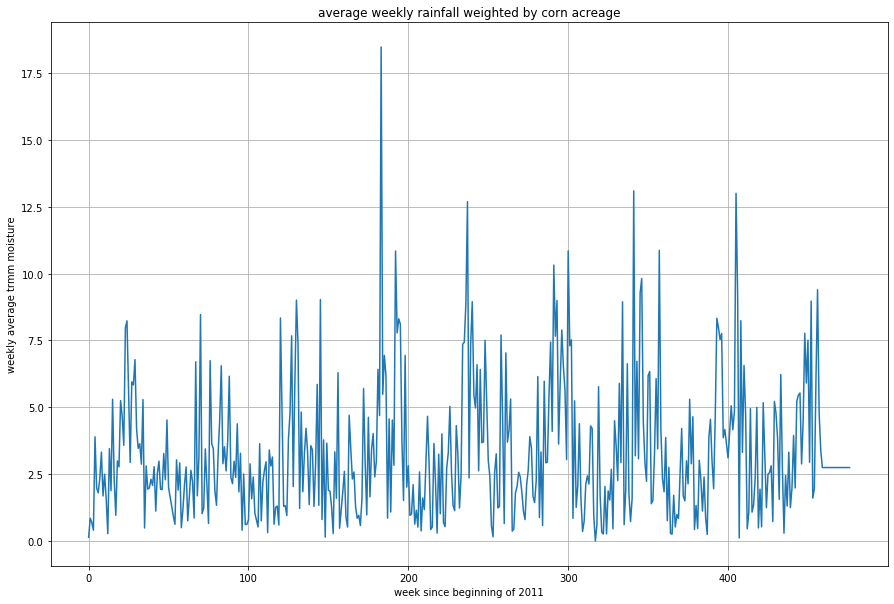

In [9]:
# weekly TRMM
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.grid()
belt_weekly_trmm_avg = ((county_trmm_data['trmm'] * yearly_data['acreage'].reindex(county_trmm_data.index)).sum(level=['year','week'])/
                             yearly_data['acreage'].sum(level='year')).values

# Note: in pandas 0.25 this can be done in a cleaner way (without reindex):
#belt_weekly_trmm_avg = ((county_trmm_data['trmm'] * yearly_data['acreage']).sum(level=['year','week'])/
#                             yearly_data['acreage'].sum(level='year')).values

ax.plot(belt_weekly_trmm_avg)
ax.set_xlabel("week since beginning of "+str(start_year))
ax.set_ylabel("weekly average trmm moisture")
ax.set_title("average weekly rainfall weighted by " + crop + " acreage")

Text(0.5, 1.0, 'average soil moisture weighted by corn acreage')

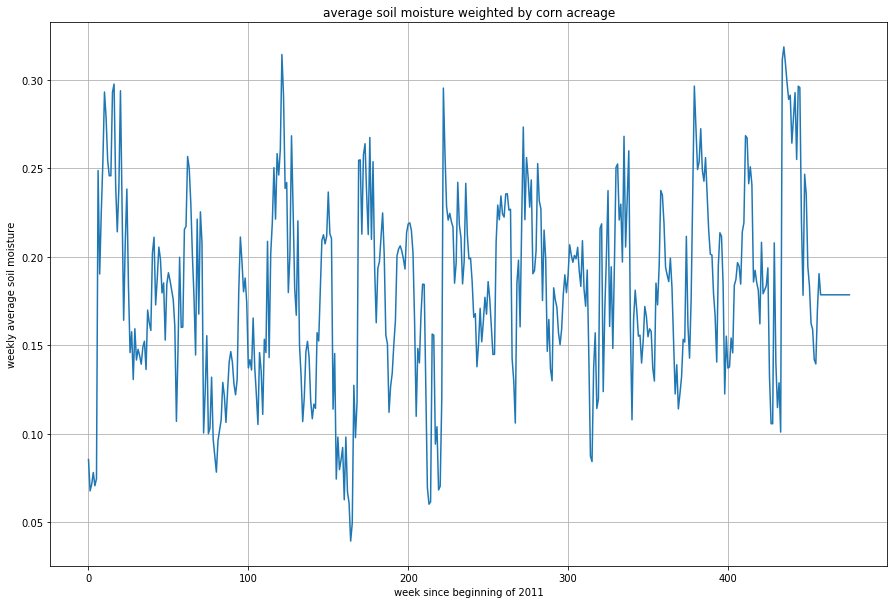

In [10]:
# weekly SMOS
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.grid()
belt_weekly_smos_avg = ((county_smos_data['smos'] * yearly_data['acreage'].reindex(county_smos_data.index)).sum(level=['year','week'])/
                             yearly_data['acreage'].sum(level='year')).values

ax.plot(belt_weekly_smos_avg)
ax.set_xlabel("week since beginning of "+ str(start_year))
ax.set_ylabel("weekly average soil moisture")
ax.set_title("average soil moisture weighted by " + crop + " acreage")

Text(0.5, 1.0, 'corn progress average over states and years')

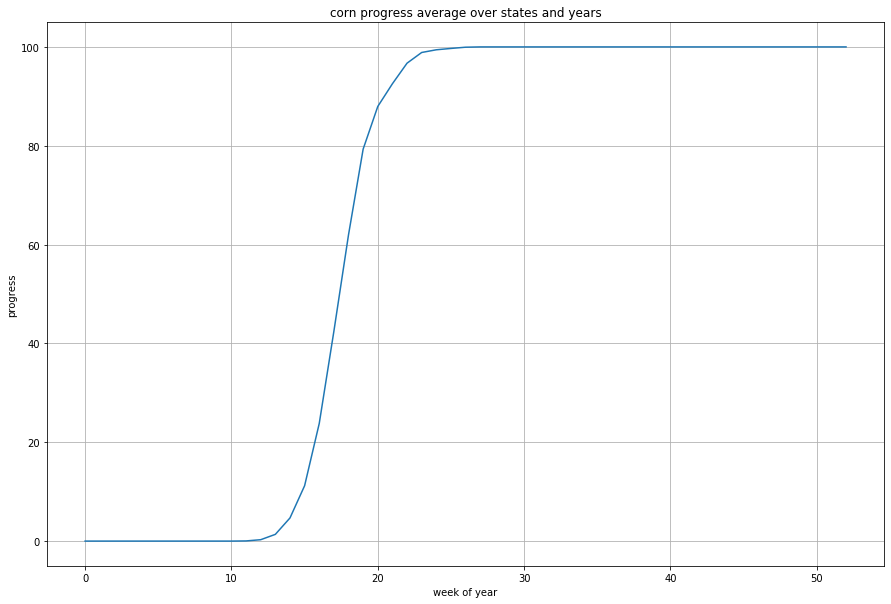

In [11]:
# Planting progress
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.grid()
weekly_prog_avg = ((state_progress_data['prog'] * yearly_data['acreage'].reindex(state_progress_data.index)).
                             sum(level=['week'])/yearly_data['acreage'].sum()).values

ax.plot(weekly_prog_avg)
ax.set_xlabel("week of year")
ax.set_ylabel("progress")
ax.set_title(crop + " progress average over states and years")

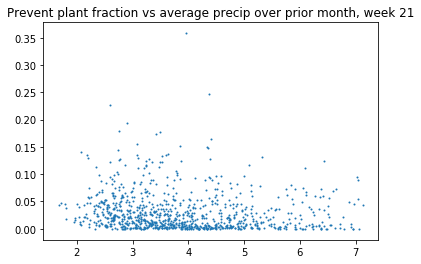

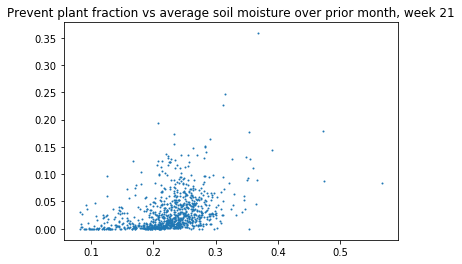

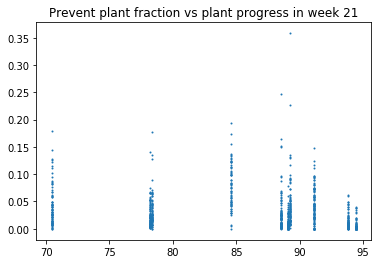

In [12]:
# A few simple exploratory plots to see the dependence on our variables
# To enhance trends, for each countty we take a specific week and average
# over all available years
plot_week = 21
y_data = (yearly_data["fsa_area_prevented_non_irrigated_"+crop]/
          yearly_data['acreage']).groupby('county').mean()#.loc[pd.IndexSlice[:,plot_year]]
plt.scatter(county_trmm_data.sort_index().
            loc[pd.IndexSlice[:,:,plot_week:plot_week+1],'trmm'].groupby('county').mean(),
         y_data, s=1)
plt.title('Prevent plant fraction vs average precip over prior month, week {}'.format(plot_week))
plt.show()

plt.title('Prevent plant fraction vs average soil moisture over prior month, week {}'.format(plot_week))
plt.scatter(county_smos_data.sort_index().
            loc[pd.IndexSlice[:,:,plot_week-4:plot_week+1],'smos'].groupby('county').mean(),
         y_data, s=1)
plt.show()

plt.scatter(state_progress_data.loc[pd.IndexSlice[:,:,plot_week],'prog'].groupby('county').mean(),y_data, s=1)
plt.title('Prevent plant fraction vs plant progress in week {}'.format(plot_week))
plt.show()

# STAGE III: Building models
"non-irrigated" prevented plant acres vastly outnumber irrigated ones so we are using this as the ratio of interest for the model and this is what we will be forecasting. Remember that data for this year (i.e. end_year), even if available, is not to be trusted if the model is run in the early weeks of planting season.

 A common question is whether to drop or fill in missing data. In this case it is the fraction prevented (y) which has missing data while we filled in all explanotary variables earlier. One could also have situation where some of X are missing, of course.
 
 So if we don't have prevented fraction data for particular county/year, do we assume, say, zero prevention or simply skip this point altogether? One can argue eiethr way, but we will skip as most of such data seems to be for counties with little/no crop.

 Two model types will be build - a linear regression and a boost trees based model. In all cases we will use the sequence of prior weekly data for a given year from start_week onward as explanotary variables. Each such week adds 3 separate variables (TRMM, SMOSS, PROGRESS). For boosting trees only we will also use county geographic location. This should allow to learn a county-level "map" of factors consistently affecting planting process beyond variables already considered.

Creating model(s) for period from week 14 (starting 2019-04-01) to week 14 (ending 2019-04-14)
OOS county-level mean square error, linear: 14,956,980, gbt: 16,628,665
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"766,753","658,509","1,676,176"
2012,"619,153","880,254","114,707"
2013,"939,496","646,897","2,156,016"
2014,"900,312","1,311,374","707,309"
2015,"674,701","557,353","1,006,176"
2016,"570,598","513,507","299,299"
2017,"1,173,175","1,164,736","412,401"
2018,"1,339,916","1,056,478","252,299"
2019,nan,nan,"8,294,548"


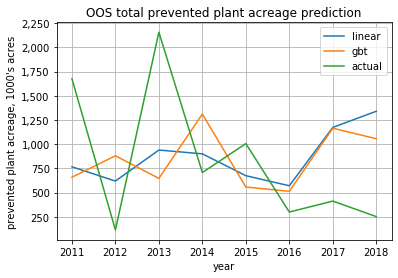

Week 14 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,270,284","1,396,413","1,676,176",in
2012,"759,773","454,617","114,707",in
2013,"1,549,206","1,356,829","2,156,016",in
2014,"1,225,233","1,053,758","707,309",in
2015,"1,081,974","878,908","1,006,176",in
2016,"906,316","646,792","299,299",in
2017,"1,373,357","1,043,685","412,401",in
2018,"1,424,880","950,844","252,299",in
2019,"1,856,567","1,981,123","8,294,548",out


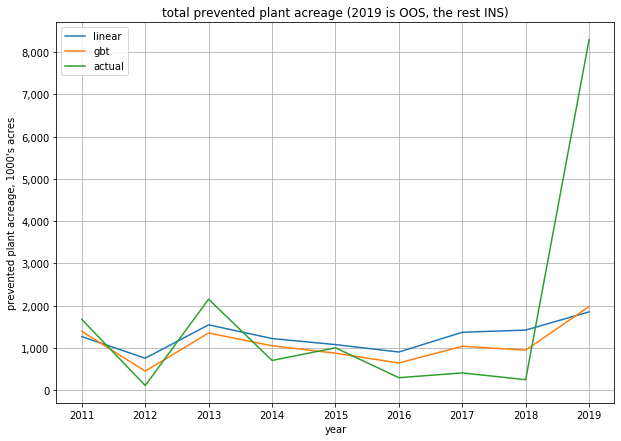

Creating model(s) for period from week 14 (starting 2019-04-01) to week 15 (ending 2019-04-21)
OOS county-level mean square error, linear: 14,854,296, gbt: 14,105,564
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"815,575","988,082","1,676,176"
2012,"338,973","532,897","114,707"
2013,"1,041,237","739,020","2,156,016"
2014,"989,950","1,135,043","707,309"
2015,"726,717","894,003","1,006,176"
2016,"752,431","483,836","299,299"
2017,"921,185","927,714","412,401"
2018,"1,494,021","1,321,077","252,299"
2019,nan,nan,"8,294,548"


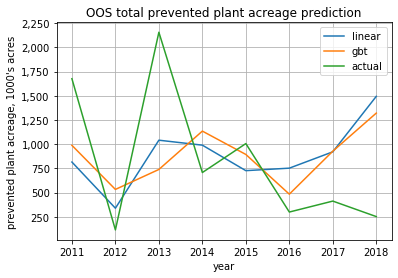

Week 15 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,343,470","1,398,205","1,676,176",in
2012,"381,003","314,019","114,707",in
2013,"1,778,605","1,641,955","2,156,016",in
2014,"1,249,680","1,121,134","707,309",in
2015,"1,063,166","1,010,971","1,006,176",in
2016,"813,384","411,875","299,299",in
2017,"993,005","733,578","412,401",in
2018,"1,500,797","1,051,362","252,299",in
2019,"1,994,764","2,226,271","8,294,548",out


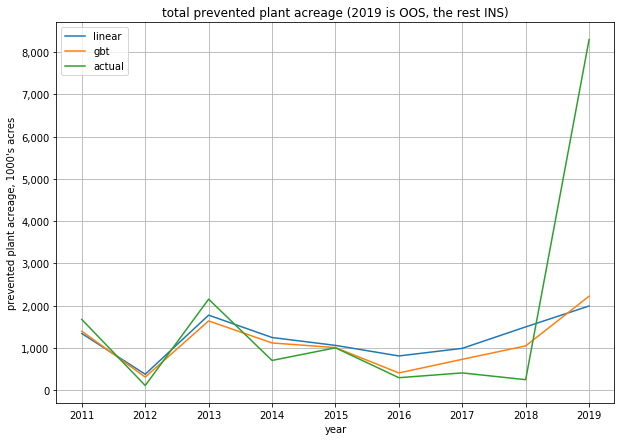

Creating model(s) for period from week 14 (starting 2019-04-01) to week 16 (ending 2019-04-28)
OOS county-level mean square error, linear: 14,793,123, gbt: 20,089,742
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"1,155,468","1,470,229","1,676,176"
2012,"297,877","2,184,944","114,707"
2013,"1,494,716","1,557,376","2,156,016"
2014,"911,560","859,319","707,309"
2015,"524,557","616,995","1,006,176"
2016,"548,758","346,339","299,299"
2017,"714,896","813,980","412,401"
2018,"1,553,590","1,278,555","252,299"
2019,nan,nan,"8,294,548"


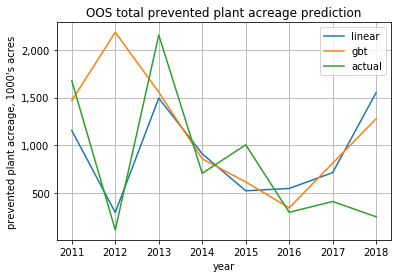

Week 16 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,866,398","1,760,172","1,676,176",in
2012,"319,536","287,955","114,707",in
2013,"2,093,342","2,017,825","2,156,016",in
2014,"1,079,857","958,364","707,309",in
2015,"883,559","992,108","1,006,176",in
2016,"641,045","286,786","299,299",in
2017,"807,124","602,124","412,401",in
2018,"1,402,340","834,885","252,299",in
2019,"1,872,031","1,844,904","8,294,548",out


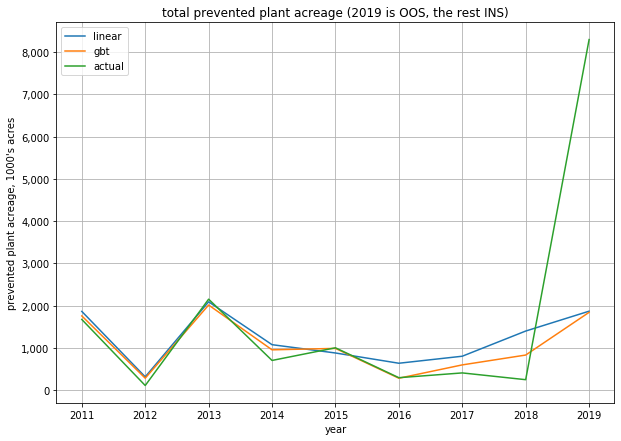

Creating model(s) for period from week 14 (starting 2019-04-01) to week 17 (ending 2019-05-05)
OOS county-level mean square error, linear: 14,787,837, gbt: 23,668,785
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"1,276,872","3,393,637","1,676,176"
2012,"100,285","1,179,793","114,707"
2013,"1,615,529","1,650,343","2,156,016"
2014,"792,527","1,477,590","707,309"
2015,"584,982","556,617","1,006,176"
2016,"1,005,330","829,180","299,299"
2017,"672,950","685,894","412,401"
2018,"1,594,216","1,820,770","252,299"
2019,nan,nan,"8,294,548"


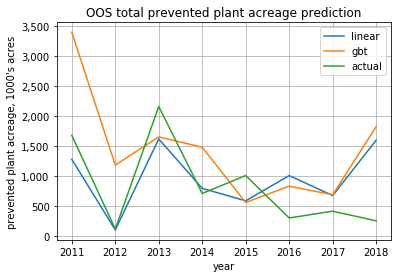

Week 17 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,973,268","1,835,288","1,676,176",in
2012,"158,059","179,821","114,707",in
2013,"2,182,444","2,073,488","2,156,016",in
2014,"1,031,727","1,037,046","707,309",in
2015,"898,470","947,480","1,006,176",in
2016,"909,200","351,584","299,299",in
2017,"734,162","521,605","412,401",in
2018,"1,307,810","738,307","252,299",in
2019,"1,838,662","1,865,731","8,294,548",out


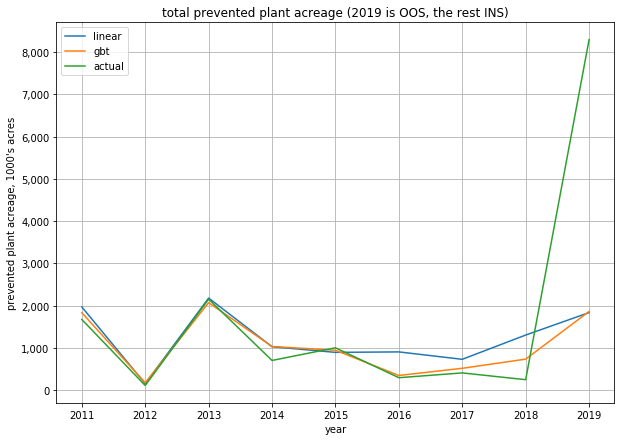

Creating model(s) for period from week 14 (starting 2019-04-01) to week 18 (ending 2019-05-12)
OOS county-level mean square error, linear: 14,916,745, gbt: 20,174,940
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"1,327,207","2,634,704","1,676,176"
2012,"298,981","708,787","114,707"
2013,"1,395,744","1,916,280","2,156,016"
2014,"1,104,013","1,595,863","707,309"
2015,"376,885","402,191","1,006,176"
2016,"818,565","641,855","299,299"
2017,"774,339","865,029","412,401"
2018,"1,553,332","2,138,784","252,299"
2019,nan,nan,"8,294,548"


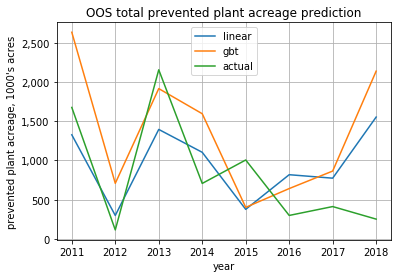

Week 18 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,953,678","1,794,926","1,676,176",in
2012,"263,255","203,109","114,707",in
2013,"1,869,022","2,035,033","2,156,016",in
2014,"1,317,119","1,125,480","707,309",in
2015,"905,906","944,423","1,006,176",in
2016,"843,297","381,556","299,299",in
2017,"1,025,473","546,361","412,401",in
2018,"1,157,579","671,530","252,299",in
2019,"1,828,430","2,074,734","8,294,548",out


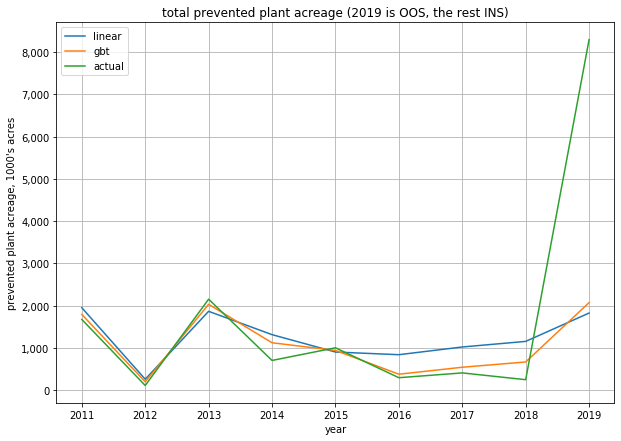

Creating model(s) for period from week 14 (starting 2019-04-01) to week 19 (ending 2019-05-19)
OOS county-level mean square error, linear: 14,644,602, gbt: 17,976,262
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"1,198,233","2,408,489","1,676,176"
2012,"498,271","919,614","114,707"
2013,"1,907,990","1,667,407","2,156,016"
2014,"878,079","1,414,483","707,309"
2015,"472,714","249,287","1,006,176"
2016,"960,062","1,000,153","299,299"
2017,"588,716","797,812","412,401"
2018,"1,401,951","1,669,454","252,299"
2019,nan,nan,"8,294,548"


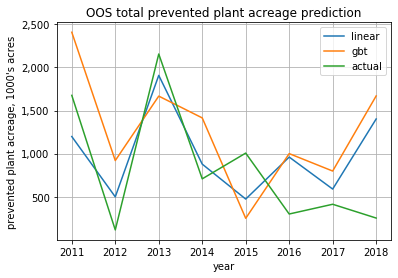

Week 19 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,912,525","1,611,464","1,676,176",in
2012,"323,356","212,457","114,707",in
2013,"2,172,405","2,166,576","2,156,016",in
2014,"1,048,093","1,028,083","707,309",in
2015,"1,233,311","918,472","1,006,176",in
2016,"944,396","466,543","299,299",in
2017,"708,548","508,478","412,401",in
2018,"1,081,103","585,422","252,299",in
2019,"2,592,034","3,538,227","8,294,548",out


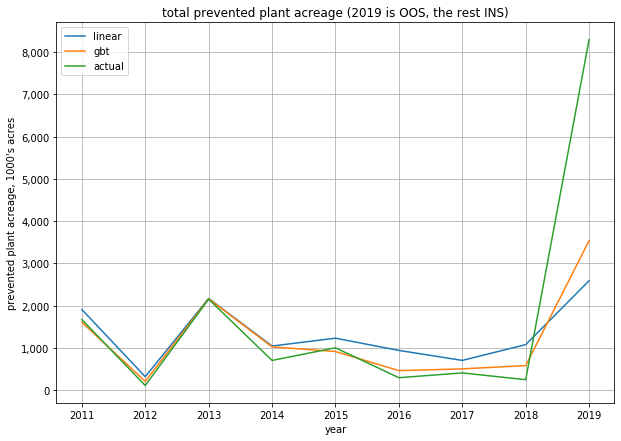

Creating model(s) for period from week 14 (starting 2019-04-01) to week 20 (ending 2019-05-26)
OOS county-level mean square error, linear: 14,989,763, gbt: 17,054,560
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"1,208,642","1,516,151","1,676,176"
2012,"246,833","773,891","114,707"
2013,"1,406,839","1,323,675","2,156,016"
2014,"959,589","1,670,391","707,309"
2015,"469,988","288,847","1,006,176"
2016,"817,142","686,579","299,299"
2017,"889,041","861,330","412,401"
2018,"1,411,608","1,750,538","252,299"
2019,nan,nan,"8,294,548"


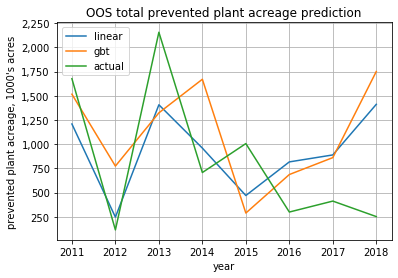

Week 20 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,925,312","1,581,497","1,676,176",in
2012,"227,105","183,115","114,707",in
2013,"2,023,683","2,159,592","2,156,016",in
2014,"1,126,632","1,030,933","707,309",in
2015,"1,369,740","962,723","1,006,176",in
2016,"797,505","390,800","299,299",in
2017,"884,508","543,597","412,401",in
2018,"1,065,890","556,356","252,299",in
2019,"2,916,685","3,380,471","8,294,548",out


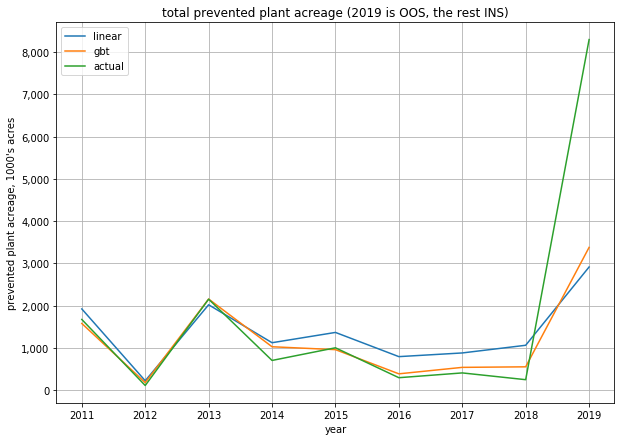

Creating model(s) for period from week 14 (starting 2019-04-01) to week 21 (ending 2019-06-02)
OOS county-level mean square error, linear: 14,935,961, gbt: 11,782,409
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"2,111,531","2,008,225","1,676,176"
2012,"200,579","561,418","114,707"
2013,"1,075,931","1,319,185","2,156,016"
2014,"460,995","948,582","707,309"
2015,"421,069","424,413","1,006,176"
2016,"1,058,879","496,464","299,299"
2017,"2,044,953","1,015,119","412,401"
2018,"1,181,351","852,880","252,299"
2019,nan,nan,"8,294,548"


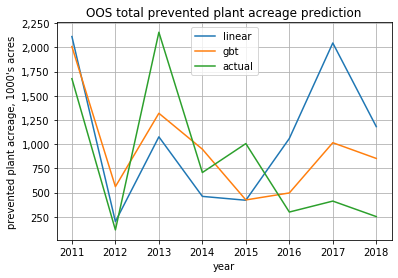

Week 21 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"2,278,596","1,854,644","1,676,176",in
2012,"185,667","165,029","114,707",in
2013,"2,027,231","2,088,183","2,156,016",in
2014,"853,334","955,705","707,309",in
2015,"1,334,726","918,782","1,006,176",in
2016,"855,955","402,826","299,299",in
2017,"1,209,214","624,296","412,401",in
2018,"972,515","420,349","252,299",in
2019,"3,601,800","4,497,169","8,294,548",out


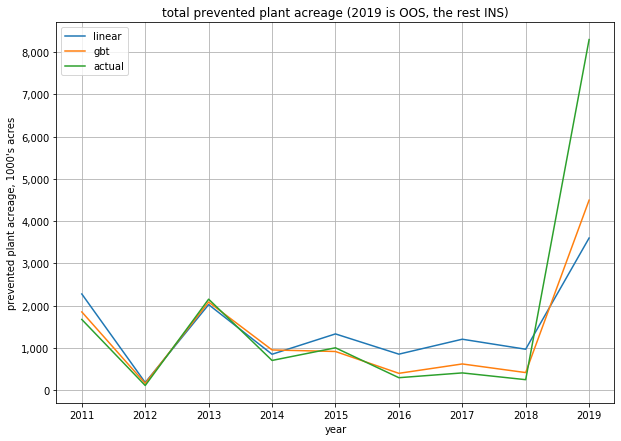

Creating model(s) for period from week 14 (starting 2019-04-01) to week 22 (ending 2019-06-09)
OOS county-level mean square error, linear: 13,585,444, gbt: 11,135,832
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"1,287,222","1,959,340","1,676,176"
2012,"232,178","440,733","114,707"
2013,"2,655,430","3,209,637","2,156,016"
2014,"639,746","858,656","707,309"
2015,"823,498","494,517","1,006,176"
2016,"1,113,828","428,365","299,299"
2017,"1,722,537","728,648","412,401"
2018,"923,980","686,636","252,299"
2019,nan,nan,"8,294,548"


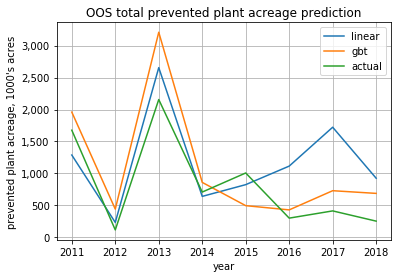

Week 22 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,954,829","1,820,180","1,676,176",in
2012,"232,751","171,895","114,707",in
2013,"2,369,833","2,158,126","2,156,016",in
2014,"1,018,319","801,805","707,309",in
2015,"1,458,761","997,765","1,006,176",in
2016,"769,375","401,445","299,299",in
2017,"976,453","458,762","412,401",in
2018,"828,307","370,295","252,299",in
2019,"6,447,381","4,825,369","8,294,548",out


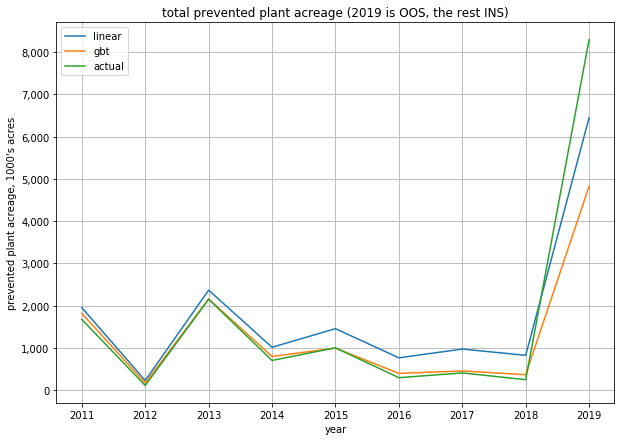

Creating model(s) for period from week 14 (starting 2019-04-01) to week 23 (ending 2019-06-16)
OOS county-level mean square error, linear: 14,149,447, gbt: 11,475,384
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"991,272","1,342,569","1,676,176"
2012,"221,334","510,640","114,707"
2013,"3,108,272","3,963,004","2,156,016"
2014,"932,594","924,353","707,309"
2015,"882,426","655,888","1,006,176"
2016,"1,118,978","418,501","299,299"
2017,"1,524,454","539,703","412,401"
2018,"810,938","569,830","252,299"
2019,nan,nan,"8,294,548"


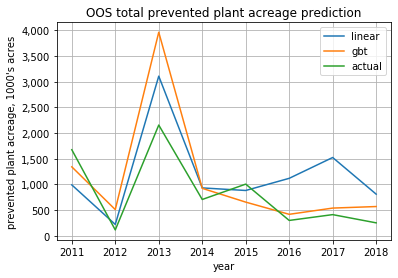

Week 23 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,873,620","1,699,504","1,676,176",in
2012,"203,412","125,885","114,707",in
2013,"2,446,841","2,229,180","2,156,016",in
2014,"1,251,301","877,655","707,309",in
2015,"1,531,189","1,041,492","1,006,176",in
2016,"769,071","349,181","299,299",in
2017,"777,207","407,788","412,401",in
2018,"736,386","328,680","252,299",in
2019,"6,077,542","5,459,098","8,294,548",out


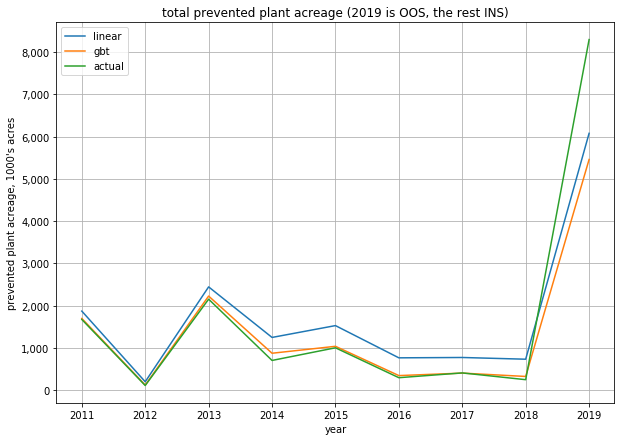

/home/ash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Creating model(s) for period from week 14 (starting 2019-04-01) to week 24 (ending 2019-06-23)
OOS county-level mean square error, linear: 14,577,949, gbt: 11,266,556
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"923,306","1,359,275","1,676,176"
2012,"277,301","398,157","114,707"
2013,"2,143,109","3,903,800","2,156,016"
2014,"1,162,120","874,946","707,309"
2015,"1,004,854","692,882","1,006,176"
2016,"1,110,214","392,517","299,299"
2017,"1,539,490","536,378","412,401"
2018,"805,848","618,758","252,299"
2019,nan,nan,"8,294,548"


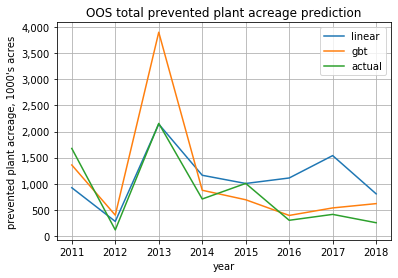

Week 24 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,838,749","1,667,519","1,676,176",in
2012,"228,472","141,621","114,707",in
2013,"2,368,523","2,181,106","2,156,016",in
2014,"1,332,346","927,725","707,309",in
2015,"1,461,218","1,045,936","1,006,176",in
2016,"770,066","339,617","299,299",in
2017,"747,750","419,205","412,401",in
2018,"707,820","340,266","252,299",in
2019,"8,554,595","6,701,577","8,294,548",out


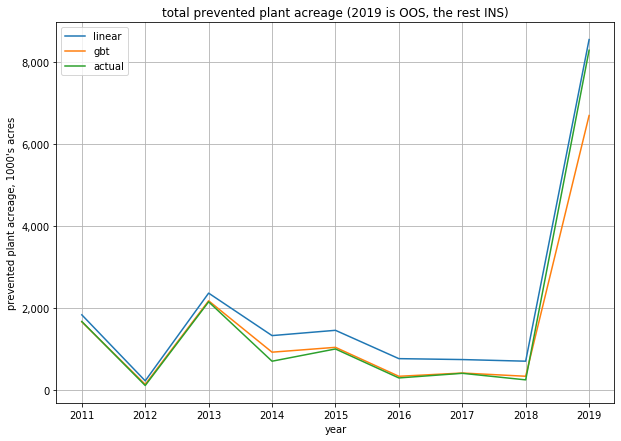

Creating model(s) for period from week 14 (starting 2019-04-01) to week 25 (ending 2019-06-30)
OOS county-level mean square error, linear: 15,412,802, gbt: 11,087,600
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"797,136","1,350,312","1,676,176"
2012,"315,728","619,105","114,707"
2013,"2,990,614","3,713,582","2,156,016"
2014,"1,306,733","888,100","707,309"
2015,"868,174","692,006","1,006,176"
2016,"1,263,106","423,858","299,299"
2017,"2,063,807","521,556","412,401"
2018,"828,180","513,401","252,299"
2019,nan,nan,"8,294,548"


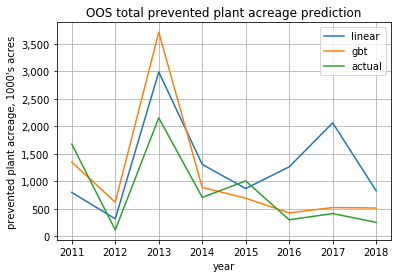

Week 25 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,783,894","1,681,927","1,676,176",in
2012,"264,632","135,143","114,707",in
2013,"2,533,703","2,179,762","2,156,016",in
2014,"1,318,678","893,784","707,309",in
2015,"1,419,282","1,051,881","1,006,176",in
2016,"822,567","335,372","299,299",in
2017,"849,170","416,808","412,401",in
2018,"717,142","357,418","252,299",in
2019,"2,079,181","7,044,386","8,294,548",out


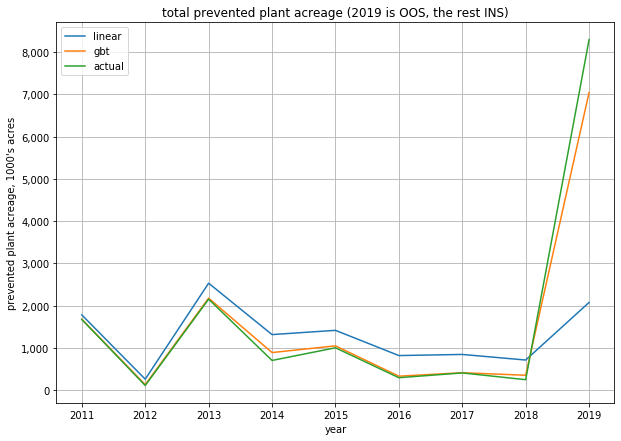

Creating model(s) for period from week 14 (starting 2019-04-01) to week 26 (ending 2019-07-07)
OOS county-level mean square error, linear: 15,838,982, gbt: 10,500,453
OOS forecasts using data from 2011 to 2018 excluding given year:


,linear,gbt,actual
2011,"744,768","1,293,809","1,676,176"
2012,"277,617","569,731","114,707"
2013,"3,180,805","3,509,419","2,156,016"
2014,"1,366,178","1,037,731","707,309"
2015,"794,840","662,226","1,006,176"
2016,"1,307,960","485,129","299,299"
2017,"2,053,356","559,519","412,401"
2018,"892,127","604,457","252,299"
2019,nan,nan,"8,294,548"


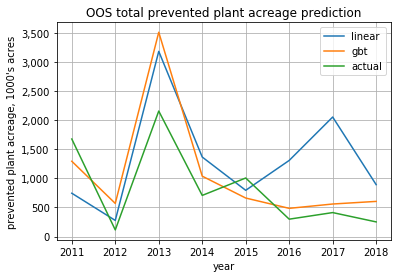

Week 26 final model results:


,linear,gbt,actual,IN/OUT-of-sample
2011,"1,760,692","1,679,241","1,676,176",in
2012,"255,912","132,366","114,707",in
2013,"2,529,707","2,213,129","2,156,016",in
2014,"1,374,790","898,818","707,309",in
2015,"1,386,283","1,043,487","1,006,176",in
2016,"828,703","308,686","299,299",in
2017,"837,823","426,947","412,401",in
2018,"719,450","390,859","252,299",in
2019,256,"6,629,796","8,294,548",out


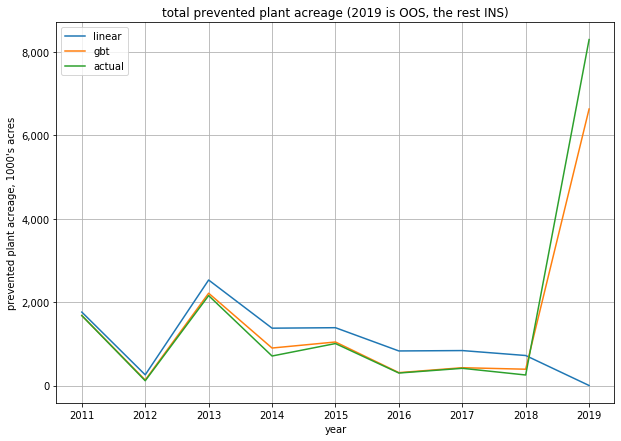

In [13]:
# We probably did sorting already but unsorted multiindexes
# is a source of very hard-to-catch bugs, so let's just do this again
county_trmm_data.sort_index(inplace=True)
county_smos_data.sort_index(inplace=True)
state_progress_data.sort_index(inplace=True)
yearly_data.sort_index(inplace=True)

# week 14 is first week of april this (2019) year
# week 26 is last week of june this (2019) year
start_week = 14

# To avoid visual clutter will take just one model to generate geopandas
# (map-like) plots. This chosen model will be using data from start_week up to and including
# backtesting_week (start_week+0 means only start_week, +1 is start_week plus next, etc.)
backtesting_week = start_week + 9

# Keeping vs. not keeping '.fillna(0)' part will toggle
# filling in vs. skipping points with missing ratio
yearly_prevent_ratio = (yearly_data["fsa_area_prevented_non_irrigated_"+crop] /
                     yearly_data['acreage'])#.fillna(0)

data_idx = yearly_prevent_ratio.notna()

# Dependent variable is always the fraction of 'prevented' for given year and county
y_all = yearly_prevent_ratio.loc[data_idx]
# exclude last year - these will be used for training
y_nolast = y_all.loc[y_all.index.get_level_values(level='year')<end_year].sort_index()
y = y_nolast.values

trmm_data = county_trmm_data.loc[data_idx,'trmm']
smos_data = county_smos_data.loc[data_idx,'smos']
progress_data = state_progress_data.loc[data_idx,'prog']
area = yearly_data.loc[data_idx,'acreage'].sort_index()

# We will also need laitude/longitude columns. These are the same for all weeks
# so we might as well compute them here
coords = county_location.loc[y_nolast.index.get_level_values(level='county')]

# For the full set we need to put IL state on top of IA for end_year (analyst suggestion)
# So we preserve full index and use to to only adjust end_year and counties in IL
# Note - this adjustment was suggested for CORN only !!!
coords_all = pd.DataFrame(y_all, columns=['y'])
coords_all = coords_all.reset_index().merge(county_location, on='county').set_index(['county','year'])
if crop == 'corn':
    coords_all.loc[(county_ids[13064],end_year),['latitude','longitude']] += [IA_IL_dlat,IA_IL_dlon]
coords_all = coords_all[['latitude','longitude']].sort_index()
start_date = datetime.datetime.strptime(f'{end_year}-W{start_week- 1}-1', "%Y-W%W-%w").date()

# Main loop to build a separate model for each week
for week_offset in range(13):
    ####################################
    # Assemble data for given interval
    ####################################
    # will build model with data from start_week up to (and including!) end_week
    # So minimal model will only have data from single week (14-th week)
    # and largest one from 14th to 26th
    end_week = start_week + week_offset
    end_date = datetime.datetime.strptime(f'{end_year}-W{end_week}-0', "%Y-W%W-%w").date()
    print('Creating model(s) for period from week {} (starting {}) to week {} (ending {})'.
          format(start_week, start_date, end_week, end_date))

    #we first cut the needed pieces from full datasets
    trmm = trmm_data.loc[trmm_data.index.isin(range(start_week,end_week+1), level='week')]
    smos = smos_data.loc[smos_data.index.isin(range(start_week,end_week+1), level='week')]
    progress = progress_data.loc[progress_data.index.isin(range(start_week,end_week+1), level='week')]
    
    # everything aligned at this point => can use the same index for all variables
    time_idx = trmm.index.get_level_values(level='year')<end_year
    
    # Put each variable to a separate column by 'unstacking' dataframe to create full
    # data matrix for model fitting (includes prior data only) ...
    X_df = pd.concat([trmm.loc[time_idx].unstack(level='week'),
                  smos.loc[time_idx].unstack(level='week'),
                  progress.loc[time_idx].unstack(level='week')], axis=1)
    # ... and one for forecasting (includes last year as well)
    X_all_df = pd.concat([trmm.unstack(level='week'),
                  smos.unstack(level='week'),
                  progress.unstack(level='week')], axis=1)
    # For boosting trees we will only add latitude/longitude
    # to explanotary variables (no change in y)
    X_gbt_df = X_df.copy()#pd.concat([X_df,coords], axis=1)
    X_gbt_df['lat'] = coords['latitude'].values
    X_gbt_df['lon'] = coords['longitude'].values
    X_all_gbt_df = pd.concat([X_all_df,coords_all], axis=1)
    
    # Ground truth, i.e. total prevented acreage
    actual = (y_all * area.values).groupby('year').sum()
    
    total_prevented = pd.DataFrame(np.nan, index=range(start_year,end_year+1), columns=['linear','gbt'])
    total_prevented['actual'] = actual
    county_prevented_full = pd.DataFrame()
    
    ##################################################################
    # A cross-validation-like loop to evaluate OOS model accuracy
    # If desired, GBT model meta-parameters could be adjusted based on such CV
    ##################################################################
    for year in range(start_year,end_year):
        # Exclude one year from fitting. Note that end_year is ALWAYS
        # excluded as well - it is not even present in X_df and y_nolast
        X_train = X_df.loc[X_df.index.get_level_values(level='year') != year,:].sort_index().values
        y_train = y_nolast.loc[y_nolast.index.get_level_values(level='year') != year].sort_index().values
        planted_area = area.loc[(area.index.get_level_values(level='year') != year) &
                                (area.index.get_level_values(level='year') != end_year)].sort_index().values
        
        ##################  Fit linear model #################################
        model_linear = sklearn.linear_model.LinearRegression().fit(X_train,y_train, sample_weight=planted_area)
        
        ################## And now GBT model (to the same y's) ##############
        X_train = X_gbt_df.loc[X_gbt_df.index.get_level_values(level='year') != year,:].sort_index().values
        model_gbt = gbt_model.fit(X_train,y_train,sample_weight=planted_area)
        
        # Generate out-of-sample forecast for prevented acreage for the omitted year
        # by both models
        X_test = X_df.loc[pd.IndexSlice[:,year,:],:].sort_index()
        X_test_gbt = X_gbt_df.loc[pd.IndexSlice[:,year,:],:].sort_index()
        y_test = y_nolast.loc[y_nolast.index.get_level_values(level='year') == year].sort_index()
        county_prevented = pd.DataFrame(np.concatenate(
            [(model_linear.predict(X_test.values)* area.loc[pd.IndexSlice[:,year]].values).reshape(-1,1),
             (model_gbt.predict(X_test_gbt.values)* area.loc[pd.IndexSlice[:,year]].values).reshape(-1,1)
            ],axis=1),
                    index=y_test.index, columns=['linear','gbt'])
        # Acrage is non-negative and does not exceeds total area,
        # so we might as well clamp our forecast
        county_prevented.clip(lower=0, upper=area, axis=0, inplace=True)
        
        county_prevented_full = pd.concat([county_prevented_full, county_prevented])
        total_prevented.loc[year,['linear','gbt']] = county_prevented.sum(axis=0)
        
    county_prevented_full.sort_index(inplace=True)
    mse_linear = mean_squared_error((y_nolast*
                    area.loc[area.index.get_level_values(level='year') != end_year]).sort_index().values, county_prevented_full['linear'].values)
    mse_gbt = mean_squared_error((y_nolast*
                    area.loc[area.index.get_level_values(level='year') != end_year]).sort_index().values, county_prevented_full['gbt'].values)
    print("OOS county-level mean square error, linear: {:,.0f}, gbt: {:,.0f}".
              format(mse_linear, mse_gbt))
    print("OOS forecasts using data from {} to {} excluding given year:".format(start_year,end_year-1))
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(total_prevented)

    fig,ax = plt.subplots(1,1)
    ax.set_title("OOS total prevented plant acreage prediction")
    ax.set_xlabel("year")
    ax.set_ylabel("prevented plant acreage, 1000's acres")
    ax.get_yaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x/1000), ',')))
    total_prevented.iloc[:-1].plot(kind='line', ax=ax)
    ax.grid()
    ax.legend()
    plt.show()

    ##########################################################
    # The final set of models for this week_offset
    # Use all available prior data, forecast end_year numbers
    ##########################################################

    # these are for fitting (excludes end_year)
    X = X_df.sort_index().values
    X_gbt = X_gbt_df.sort_index().values
    model_linear = sklearn.linear_model.LinearRegression().fit(X,y)
    model_gbt = gbt_model.fit(X_gbt,y)

    # and these are for testing. Includes end_year which is still out-of-sample
    # but all prior years are **in-sample** for final models
    X_all = X_all_df.sort_index().values
    X_all_gbt = X_all_gbt_df.sort_index().values
    county_prevented = pd.DataFrame(np.concatenate(
        [(model_linear.predict(X_all)* area.values).reshape(-1,1),
         (model_gbt.predict(X_all_gbt)* area.values).reshape(-1,1)
        ],axis=1),
            index=y_all.index, columns=['linear','gbt'])
    #county_prevented[county_prevented < 0] = 0
    county_prevented.clip(lower=0, upper=area, axis=0, inplace=True)
    total_prevented[['linear','gbt']] = county_prevented.groupby('year').sum(axis=0)
    total_prevented['IN/OUT-of-sample'] = ['in']*(end_year-start_year) +['out']

    print('Week {} final model results:'.format(end_week))
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(total_prevented)
    fig,ax = plt.subplots(1,1, figsize=(10,7))
    ax.set_title("total prevented plant acreage ({} is OOS, the rest INS)".format(end_year))
    ax.set_xlabel("year")
    ax.set_ylabel("prevented plant acreage, 1000's acres")
    ax.get_yaxis().set_major_formatter(
        FuncFormatter(lambda x, p: format(int(x/1000), ',')))
    total_prevented.plot(kind='line', ax=ax)
    ax.grid()
    ax.legend()
    plt.show()
    
    # Save results for particular week for more detailed analysis/visualization
    # (corn results will also be used by soy model extensions)
    if end_week == backtesting_week:
        backtesting_date = end_date
        county_predictions = county_prevented.loc[pd.IndexSlice[:,end_year],:]
        county_predictions.index = county_predictions.index.droplevel('year')
        # In pandas 0.25 there is a cleaner way:
        #county_predictions = county_prevented.loc[pd.IndexSlice[:,end_year],:].droplevel('year')
        
        # In pandas 0.23 SettingWithCopyWarning are given on 
        # next two assignments but there should really not be any as these are column
        # creations and should be safe (and there is no warning in 0.25)
        county_predictions['area'] = area.loc[pd.IndexSlice[:,end_year]]
        if end_year_data_available:
            county_predictions['actual'] = y_all[pd.IndexSlice[:,end_year]] * county_predictions['area']
        if crop=='corn':
            # save corn model result for possible future use by soy model
            s(county_prevented, 'model_week_{}'.format(backtesting_week), crop_name=crop)
        else:
            # We will extend GBT version of soy model with some additional data later
            # so just save copies of all X's for future use not to regenerate all the data
            # (note that y's are never changing once generated - no need to save)
            X_ext = X_gbt_df.copy()
            X_all_ext = X_all_gbt_df.copy()

# STAGE IV: Choropleth visualization of model forecasts

Note that geopandas package relies on descartes package which seems to not always getting installed along with geopandas. If you have to install separately, see https://pypi.org/project/descartes/

 GRO datasets contain geographic information on many objects (US counties in this case) making it possible to create simple map-like plots with geopandas package. To avoid excessive visual clutter here we will only look at GBT forecasts from a single model generated for backtesting_week (which was set in the previous section). Extensions to visualize results of other models versions is straightforward

In [14]:
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import shape

county_data = geopandas.GeoDataFrame([
    {
        'county': county_id, 
        'geometries': shape(client.get_geojson(county_id)['geometries'][0])
    } 
    for county_id in all_counties
])
county_data = county_data.set_geometry("geometries").set_index('county')

Text(0.5, 1, 'prevent plant fraction of total planted area, GBT prediction,\n model from week ending 2019-06-16')

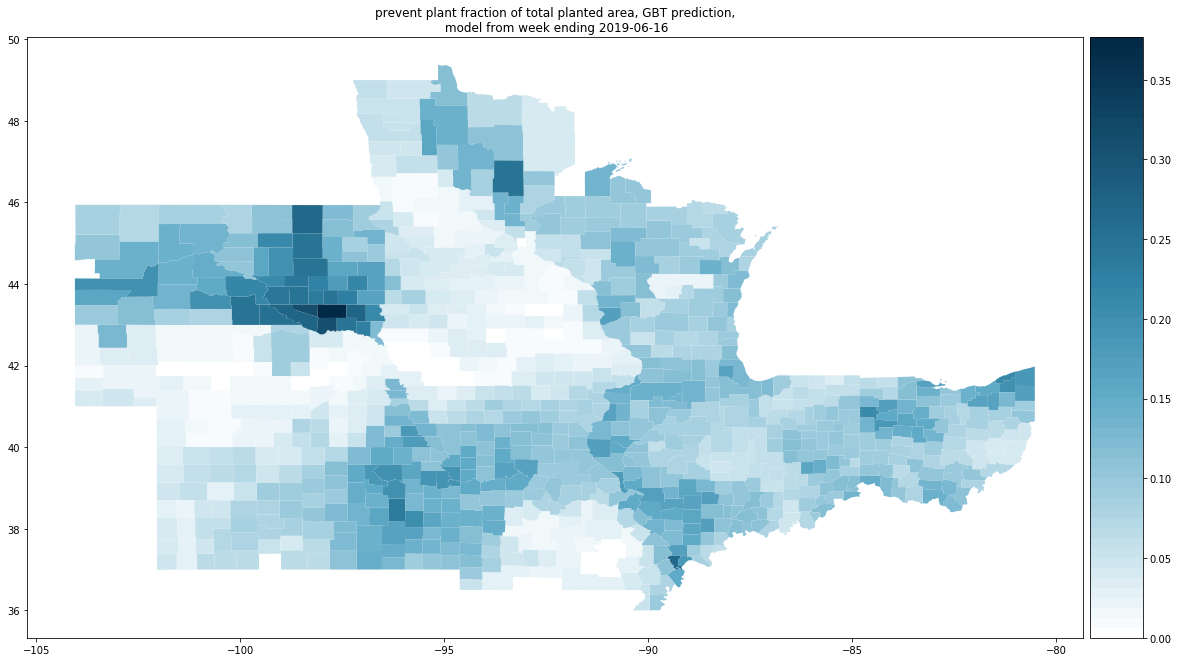

In [15]:
# We might not have forecasts for the entire set of counties due to various missing data
# Just use zero for these (but we might still have a valid planted area)
county_data['gbt'] = county_predictions['gbt']
tmp = yearly_data.loc[pd.IndexSlice[:,end_year],'acreage']
tmp.index = tmp.index.droplevel('year')
county_data['area'] = tmp
# Again, can be done better with pandas 0.25
#county_data['area'] = yearly_data.loc[pd.IndexSlice[:,end_year],'acreage'].droplevel('year')
county_data["prevented_ratio_gbt"] = (county_data['gbt']/county_data['area']).fillna(0)
blue_shades = np.array([
    (255, 255, 255),
    (175, 213, 227), 
    (97, 171, 199), 
    (47, 129, 163),
    (24, 85, 118), 
    (2, 41, 70)])/255.0
fig, ax = plt.subplots(1, 1, figsize=(20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)    
blue_cmap = LinearSegmentedColormap.from_list('blue_shades', 
                                            blue_shades, N=len(blue_shades)*10)
county_data.plot("prevented_ratio_gbt", legend=True, ax=ax, cax=cax, cmap=blue_cmap)
ax.set_title("prevent plant fraction of total planted area, GBT prediction,\n model from week ending {}".format(backtesting_date))

Text(0.5, 1, 'For reference: Total planted area')

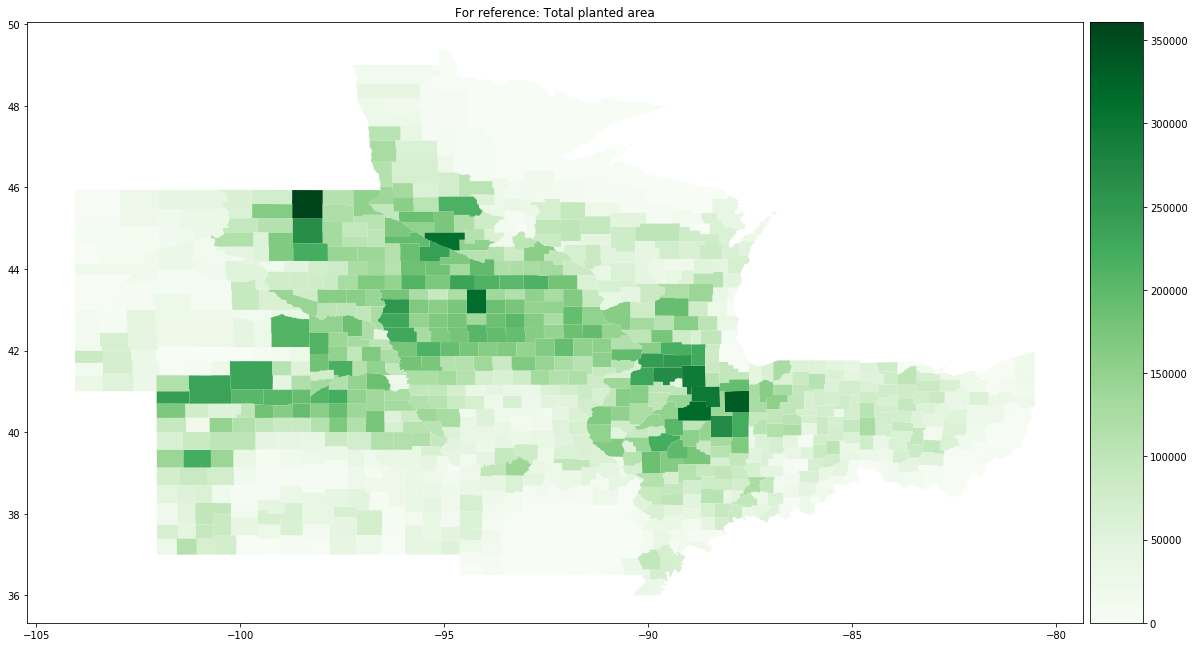

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
county_data.plot("area", legend=True, ax=ax, cax=cax, cmap='Greens')
ax.set_title("For reference: Total planted area")

If we have end_year data we can look at county-level errors (do not run this cell if end_year data is not yet available and/or make sure end_year_data_available is set accordingly)

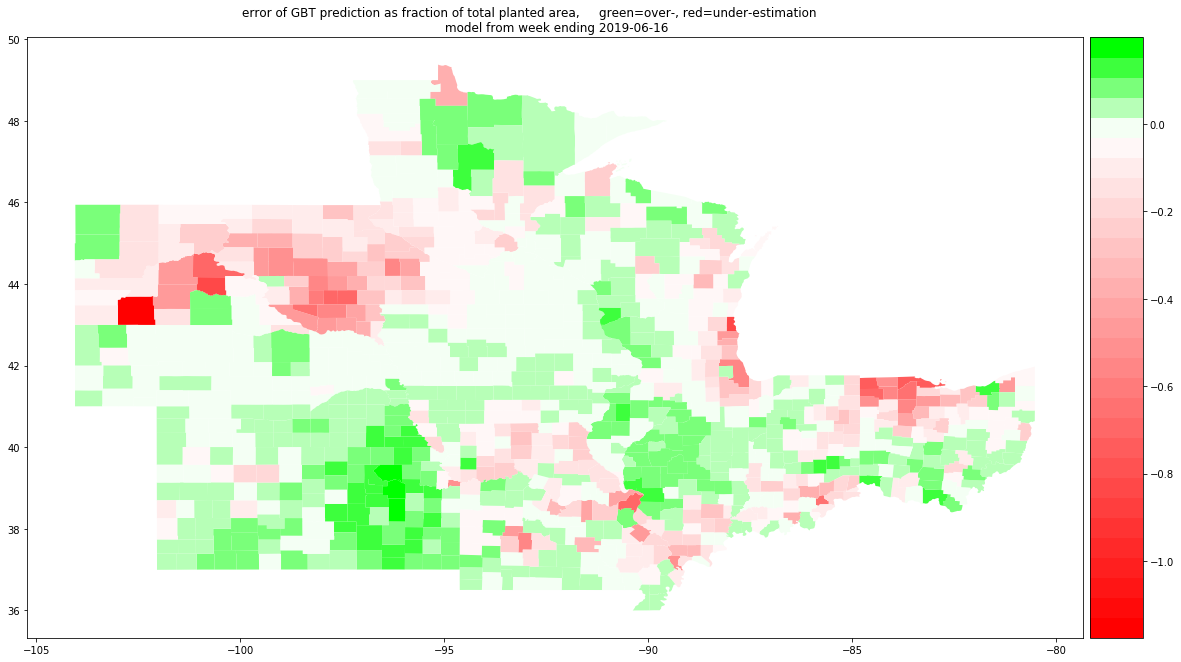

In [17]:
if end_year_data_available:
    county_data['error_gbt'] = ((county_data['gbt'] - county_predictions['actual'])/
                                county_predictions['area']).replace([np.inf, -np.inf], np.nan).fillna(0)
    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)   
    ymin=county_data['error_gbt'].min()
    ymax=county_data['error_gbt'].max()
    if ymin*ymax < 0: # min is negative, max is positive
        midpoint = -ymin/(ymax-ymin)
        err_colors = [(0, (1.0, 0, 0)),
            (midpoint,(1,1,1)),
            (1,(0, 1, 0))]
    elif ymin>=0: # all errors are +ve => make everything green
        err_colors = [(0, (1, 1, 1)),
            (1,(0, 1, 0))]
    else: # all errors are -ve => make everything red, invert scale (smaller abs error less red)
       err_colors = [(0, (1, 0, 0)),
        (1,(1, 1, 1))] 
    
    cmap_err = LinearSegmentedColormap.from_list('err_map', 
                                            err_colors, N=len(err_colors)*10)
    
    county_data.plot('error_gbt', legend=True, ax=ax, cax=cax, cmap=cmap_err)
    ax.set_title("error of GBT prediction as fraction of total planted area, \
    green=over-, red=under-estimation\
             \n model from week ending {}".format(backtesting_date))

# THIS IS THE FINAL STOP FOR THE CORN MODEL
### Cells below show a few extensions which are implemented for soy model only. 
### They will NOT run with crop='corn'

# STAGE V: Extensions

We will attempt to improve soy model by using forecasts generated by corn PP model. Note that these are only available for a subsent of counties (those within corn belt and having necessary data) so only a geographically limited extension of the general soy model will be possible. As an example of using additional variables we will also add a set of soil properties (note that these could have been useful for the original corn PP model as well but we chose not to include them for simplicity)

### Load additional data for experiments with soy model:

 
 1. CORN PP model forecasts (from specific backtesting_week, county-level) - should be generated by earlier runs of this notebook with crop='corn' and the same backtesting_week value
 2. CORN planting progress (weekly, state-level)
 3. Soil properties (static, county-level)
 

In [18]:
# load county_prevented data frame indexed by (county,year) with columns 'linear' and 'gbt'
# For year=end_year it is OOS forecast, the rest are in-sample
corn_model_result_loaded = False
if crop == 'soy':
    try:
        with open("model_week_{}_corn.pickle".format(backtesting_week), "rb") as handle:
            corn_county_prevented = pickle.load(handle)
            # will be used as index, ok to leave as such
            corn_model_coverage = corn_county_prevented.index.get_level_values(level='county').unique()
            corn_model_result_loaded = True
    except:
        print("Can not load CORN model results for week {}.\n\
Make sure that this notebook was successfully run with crop='corn' and backtesting_week={}\n".
              format(backtesting_week,backtesting_week))
        raise


In [19]:
########################
# CORN planting progress
########################
#
# This code is amost completely copy/paste of soy plant progress data collection
# changing just final df name and item_id to corn (could refactor into a separate
# procedure if needed)
# Previously cached corn progress file can be reused, but this is just one time series per
# state, so leave for now
if crop == 'soy' and corn_model_result_loaded:
    
    try: 
        corn_state_progress_data = l("state_progress_data_pd", crop_name='corn')
    except:
        print("Can not load cached corn progress data.\n\
Make sure that this notebook was successfully run with crop='corn'")
        raise
    corn_progress = corn_state_progress_data.loc[corn_state_progress_data.index.
                            isin(range(start_week,backtesting_week+1), level='week')].unstack()

We will be extending soy model only where corn model is available, but will simply load all available soil data on the first run

In [20]:
%%time
if crop=='soy' and corn_model_result_loaded:
    try: 
        soil_data = l("soil_data_pd")
    except:
        print("no cached soil data file")
        soil_properties = {
            # Soil water storage from 0 to 5 cm deep - Availability in soil (length) - US Soybean Belt States (gSSURGO)
            'aws0_5': {
                'metric_id': 15530031,
                'item_id': 8808, 
                'source_id': 87, 
                'frequency_id': 15, # static
            },
            # Soil organic carbon stock from 0 to 5 cm deep - Availability in soil (mass/area) - US Soybean Belt States (gSSURGO)
            'soc0_5': {
                'metric_id': 15530037, 
                'item_id': 8819, 
                'source_id': 87, 
                'frequency_id': 15, # static
            },
            # Corn and soybeans - Crop productivity index - US Soybean Belt States (gSSURGO)
            'nccpics':{
                'metric_id': 15540029, 
                'item_id': 8830, 
                'source_id': 87, 
                'frequency_id': 15, # static
            },
        }
        soil_data=pd.DataFrame()
        for soil_prop, query in soil_properties.items():
            df_soil_prop = []
            for county in all_counties: #corn_county_prevented.index.get_level_values(level='county').unique():
                query['region_id'] = county
                res = client.get_data_points(**query)[0]
                df_soil_prop.append([res['region_id'],res['value']])
            soil_data = pd.concat([soil_data,pd.DataFrame(df_soil_prop,columns=['county',soil_prop]).
                         set_index('county')],axis=1)
        if overwrite_prior_data:
            s(soil_data, "soil_data_pd")

    # Get only counties for which corn model is available and replicate by year
    soil_data = pd.concat([soil_data.loc[corn_model_coverage]]
                      *(end_year-start_year+1), 
          keys=range(start_year,end_year+1),
          names=['year']).reorder_levels([1,0]).sort_index()


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


## Experiment with different sets of variables
Our dataset augmented with corn data will be significantly smaller than the full soy dataset. For a fair model comparison we need to refit models on this shorter series.

Note that we perform very limited comparison based on just the MSE of end_year result. Much more extensive investigation is needed to arive at best possible model.

In [21]:
# Cut all variables to minimum available subset of (county,year)
# soil properties were loaded for counties in corn_county_prevented => no extra restrictions
if crop=='soy' and corn_model_result_loaded:
    idx = X_all_ext.index.intersection(corn_county_prevented.index).intersection(corn_progress.index)
    area_ext = area.loc[idx].sort_index()
    y = y_all.loc[idx].sort_index()

    # Describes various sets of variables we want to include
    model_specs = [['original'],
                ['original','corn_progress'],
                ['original','corn_model'],
                ['original','soil_data'],
                ['original','corn_progress','corn_model'],
                ['original','corn_progress','corn_model','soil_data']]
    for spec in model_specs:
        dataset = []
        for var in spec:
            if var == 'original':
                dataset += [X_all_ext.loc[idx]]
            if var == 'corn_model':
                dataset += [corn_county_prevented.loc[idx]]
            if var == 'corn_progress':
                dataset += [corn_progress.loc[idx]]
            if var == 'soil_data':
                dataset += [soil_data.loc[idx]]

        X_all = pd.concat(dataset,axis=1).sort_index()
    
        # Fit GBT model to pre-end_year data
        model_gbt = gbt_model.fit(X_all[X_all.index.get_level_values(level='year') != end_year].values,
                          y.loc[y.index.get_level_values(level='year') != end_year].values)
        # and get projections ...
        county_prevented_ext = pd.DataFrame(
             (model_gbt.predict(X_all.values)* area_ext.values).reshape(-1,1),
                index=X_all.index, columns=['gbt_ext'])
        # ... for end_year
        prevented_end_year = county_prevented_ext.clip(lower=0,
                                    upper=area_ext, axis=0).loc[pd.IndexSlice[:,end_year],:]
        prevented_end_year.index = prevented_end_year.index.droplevel('year')
        # also simpler in pandas 0.25
        #prevented_end_year = county_prevented_ext.clip(lower=0,
        #                            upper=area_ext, axis=0).loc[pd.IndexSlice[:,end_year],:].droplevel('year')
        
        # county_predictions were saved from earlier
        actual = county_predictions.loc[prevented_end_year.index,'actual']
        print('MSE for model {} : {:,.0f}'.format(spec,mean_squared_error(prevented_end_year,actual)))
    
        # Uncomment remaining lines to see actual vs. predicted PP ratio scatterplots for each model
        #fig, ax = plt.subplots(1, 1, figsize=(5,5))
        #ax.grid()
        #plt.scatter(prevented_end_year['gbt_ext']/area_ext.loc[pd.IndexSlice[:,end_year]],
        #            actual/area_ext.loc[pd.IndexSlice[:,end_year]],s=1)
        #plt.show()